In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.interpolate import interp1d
from hkvpy import plotting
import json
import seaborn as sns

plotting.set_rcparams()

%config InlineBackend.figure_format='retina'

In [3]:
with open('../scripts/settings.json') as f:
    dct = json.load(f)

In [4]:
# Read results from csv
# drop_sa_method = ["Kolmogorov-Smirnov"]
results = (
    pd.read_excel("../data/results/DM_results_SA_only.xlsx", index_col=[0, 1, 2], header=[0, 1])
#     .drop(drop_sa_method, axis=1, level=1)
#     .drop(drop_sa_method, axis=0, level=2)
    # .drop("ITopt", level=0, axis=1)
).loc[dct['files']]

In [6]:
# means = (results_SA_only.loc[slice(None), 'GLopt'] - results_SA_only.loc[slice(None), 'GL']).groupby(level=[1, 2]).mean()
# print(means.mean().mean())

# tmpdf1 = means.loc[('PWL', scoring_rules), scoring_rules].round(2)
# tmpdf1.index = pd.MultiIndex.from_product([['Statistical accuracy'], tmpdf1.index.get_level_values(1)])


abbrev = {
    "Chi-square": "${\chi^2}$",
    "CRPS": "CRPS",
    "Kolmogorov-Smirnov": "KS",
    "Cramer-von Mises": "CvM",
    "Anderson-Darling": "AD",
}

sa_keys = list(abbrev.values())

tmpdf = results.rename(index=abbrev, columns=abbrev).groupby(level=[1, 2]).mean().T.stack(0)
tmpdf = tmpdf.reorder_levels(order=[2, 0, 1], axis=0).sort_index()

for dist in ['PWL', 'Metalog']:
    eq_df = tmpdf.loc[(dist, 'Equal'), :]
    values = [eq_df.iat[i, i] for i in range(5)]
    for dm in ['GL', 'GLopt']:
        tmpdf.loc[(dist, dm, slice(None)), 'EQ'] = values

tmpdf = tmpdf.loc[(['PWL', 'Metalog'], ['GL', 'GLopt'], sa_keys), sa_keys + ['EQ']]

styled = tmpdf.style.format(decimal=".", thousands=",", precision=2)
#     .to_latex(hrules=True, clines="skip-last;data")
# )

text = styled.to_latex(hrules=True, clines='skip-last;data', multicol_align='c', )

text = text.replace('PWL', 'PWU')
text = text.replace('Distribution', 'Dist.')
text = text.replace('SA_score', 'SA (sc.)')
text = text.replace('SA_weight', 'SA (w.)')

for word in ['Metalog', 'GLopt', 'GL', 'PWU']:
    text = text.replace('{'+word+'}', r'{\rotatebox[origin=c]{90}{'+word+'}}')

for word in ['Dist.', 'DM', ]:
    text = text.replace(word, r'\rotatebox[origin=c]{90}{'+word+'}')

with open('../data/tables/sa_scores.tex', 'w') as f:
    f.write(r'\setlength\tabcolsep{5pt}')
    f.write('\n')
    f.write(text)

# tmpdf.to_excel('scores.xlsx')


In [7]:
tmpdf

SA_weight                      ${\chi^2}$      CRPS        KS       CvM  \
Distribution DM    SA_score                                               
PWL          GL    ${\chi^2}$    0.398968  0.360449  0.433697  0.455654   
                   CRPS          0.627283  0.668405  0.672209  0.673072   
                   KS            0.519130  0.405170  0.570014  0.552545   
                   CvM           0.506390  0.397072  0.561894  0.569810   
                   AD            0.509811  0.389121  0.558310  0.567336   
             GLopt ${\chi^2}$    0.545797  0.380282  0.387539  0.375987   
                   CRPS          0.501067  0.617745  0.348440  0.359142   
                   KS            0.487025  0.415062  0.706740  0.674806   
                   CvM           0.494579  0.428326  0.691103  0.718630   
                   AD            0.491923  0.435757  0.629112  0.657125   
Metalog      GL    ${\chi^2}$    0.389817  0.327543  0.455010  0.438532   
                   CRPS          0.476922  0.463896  0.540406  0.557816   
                   KS            0.508407  0.434922  0.579610  0.580021   
                   CvM           0.504031  0.430479  0.586272  0.596232   
                   AD            0.454124  0.355765  0.534372  0.542194   
             GLopt ${\chi^2}$    0.516976  0.324880  0.421132  0.428249   
                   CRPS          0.340535  0.458804  0.266720  0.309447   
                   KS            0.444816  0.438501  0.700118  0.698465   
                   CvM           0.460297  0.436520  0.673217  0.713028   
                   AD            0.338640  0.358469  0.388023  0.465800   

SA_weight                            AD        EQ  
Distribution DM    SA_score                        
PWL          GL    ${\chi^2}$  0.419161  0.315922  
                   CRPS        0.672987  0.691505  
                   KS          0.543682  0.387832  
                   CvM         0.548144  0.378171  
                   AD          0.552097  0.386927  
             GLopt ${\chi^2}$  0.431853  0.315922  
                   CRPS        0.423962  0.691505  
                   KS          0.659890  0.387832  
                   CvM         0.680997  0.378171  
                   AD          0.652410  0.386927  
Metalog      GL    ${\chi^2}$  0.367943  0.323652  
                   CRPS        0.396791  0.585407  
                   KS          0.457230  0.398570  
                   CvM         0.448067  0.393794  
                   AD          0.364676  0.403472  
             GLopt ${\chi^2}$  0.401629  0.323652  
                   CRPS        0.327051  0.585407  
                   KS          0.487612  0.398570  
                   CvM         0.498130  0.393794  
                   AD          0.411775  0.403472

In [8]:

# results.drop('CRPS+LR', axis=1, level=1, inplace=True)
# results.drop('CRPS+LR', axis=0, level=2, inplace=True)
# For both the uniform and metalog
# distribution = 'Metalog'
# distribution = 'PWL'

# For each DM
# dm = 'Global Non-opt.'
# dm = 'Glob opt.'

# Get the empirical distribution of the source SA method
dms = results.columns.get_level_values(0).unique().tolist()
dists = results.columns.get_level_values(1).unique().tolist()
dists = [
 'Chi-square',
    'CRPS',
    'Kolmogorov-Smirnov',
 'Cramer-von Mises',
 'Anderson-Darling']
distributions = results.index.get_level_values(1).unique().tolist()


# Compare the results for
def get_values(distribution, SA_weight, SA_score, dm):
    values = results.loc[(slice(None), distribution, SA_weight), (dm, SA_score)].to_numpy()
    return values

def get_empirical_dist_interp(distribution, SA_weight, dm):
    values = get_values(distribution, SA_weight, SA_weight, dm)
        
    order = np.argsort(np.argsort(values)).astype(float)
    u, c = np.unique(values, return_counts=True)
    if c.max() > 1:
        for i in np.where(c > 1)[0]:
            idx = values == u[i]
            order[idx] = order[idx].mean()
        
    ranks = (order + 0.5) / len(values)
    
    return interp1d(np.concatenate([[0.0], values, [max(1.0, max(values))]]), np.concatenate([[0.0], ranks, [1.0]]), fill_value = (0, 1), bounds_error=False)

empirical = {}
for dm in dms:
    for distribution in distributions:
        for SA_weight in dists:
            # Get the empirical distribution of the SA method's score
            empirical[(distribution, dm, SA_weight)] = get_empirical_dist_interp(distribution, SA_weight, dm)

In [9]:
dists

['Chi-square',
 'CRPS',
 'Kolmogorov-Smirnov',
 'Cramer-von Mises',
 'Anderson-Darling']

In [11]:
results.loc['Arkansas', 'GL']

C:\Users\gwfrongen\AppData\Local\Temp\ipykernel_13784\543239337.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc['Arkansas', 'GL']


SA_score                         Chi-square      CRPS  Kolmogorov-Smirnov  \
Distribution SA_weight                                                      
Metalog      Anderson-Darling      0.584457  0.069435            0.484654   
             CRPS                  0.498798  0.314450            0.625586   
             Chi-square            0.498798  0.248699            0.666572   
             Cramer-von Mises      0.498798  0.414063            0.607494   
             Kolmogorov-Smirnov    0.498798  0.373223            0.604914   
PWL          Anderson-Darling      0.498798  0.327483            0.790330   
             CRPS                  0.498798  0.455605            0.668979   
             Chi-square            0.498798  0.370760            0.766592   
             Cramer-von Mises      0.561870  0.596060            0.682256   
             Kolmogorov-Smirnov    0.342834  0.522635            0.668489   

SA_score                         Cramer-von Mises  Anderson-Darling  
Distribution SA_weight                                               
Metalog      Anderson-Darling            0.559659          0.180588  
             CRPS                        0.641163          0.141277  
             Chi-square                  0.717591          0.188688  
             Cramer-von Mises            0.651940          0.460546  
             Kolmogorov-Smirnov          0.649854          0.331861  
PWL          Anderson-Darling            0.762171          0.634343  
             CRPS                        0.616864          0.430776  
             Chi-square                  0.814743          0.616115  
             Cramer-von Mises            0.653498          0.567063  
             Kolmogorov-Smirnov          0.667044          0.527430

In [14]:
def get_joint_grid(ncols, nrows, figsize=(4, 3), vratio=2, ratio=3):

    margs = np.empty((nrows, ncols), dtype=object)
    joints = np.empty((nrows, ncols), dtype=object)

    def clean_marg_x(ax_marg_x):
        # Turn off tick visibility for the measure axis on the marginal plots
        plt.setp(ax_marg_x.get_xticklabels(), visible=False)
        plt.setp(ax_marg_x.get_xticklabels(minor=True), visible=False)

        # Turn off the ticks on the density axis for the marginal plots
        # if not marginal_ticks:
        plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax_marg_x.get_yticklabels(), visible=False)
        plt.setp(ax_marg_x.get_yticklabels(minor=True), visible=False)
        ax_marg_x.yaxis.grid(False)

        sns.utils.despine(ax=ax_marg_x, left=True)
        for axis in [ax_marg_x.xaxis, ax_marg_x.yaxis]:
            axis.label.set_visible(False)

    # Set up the subplot grid
    f = plt.figure(figsize=figsize)
    gs = plt.GridSpec((ratio + 1) * nrows * vratio + (nrows-1), ratio * ncols)

    for i in range(nrows):
        for j in range(ncols):
            vstart = (i * (ratio + 1) + 1) * vratio + i
            vend = ((i + 1) * (ratio + 1)) * vratio + i
            hstart = j * ratio
            hend = (j + 1) * ratio

            ax_joint = f.add_subplot(gs[vstart:vend, hstart:hend])
            ax_marg_x = f.add_subplot(gs[vstart - vratio: vstart, hstart:hend], sharex=ax_joint)
            clean_marg_x(ax_marg_x)

            margs[i, j] = ax_marg_x
            joints[i, j] = ax_joint

    sns.utils.despine(f, left=True)

    #     f.set_tight_layout('tight')

    return f, joints, margs

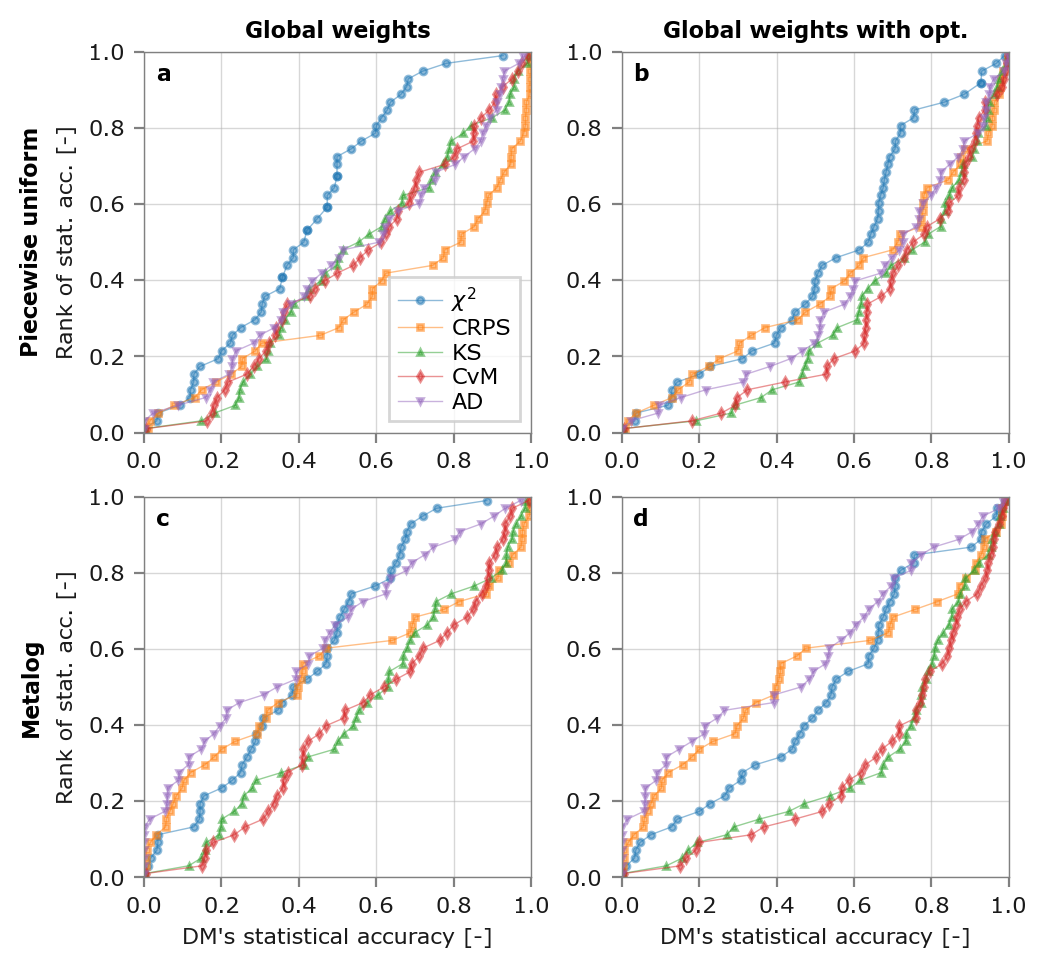

In [16]:
from scipy.stats import gaussian_kde, beta

ncols = 2
nrows = 2

colors = {
    "Chi-square": 'C0',
    "CRPS": 'C1',
    "Kolmogorov-Smirnov": 'C2',
    "Cramer-von Mises": 'C3',
    "Anderson-Darling": 'C4',
}

markers = {
    "Chi-square": 'o',
    "CRPS": 's',
    "Kolmogorov-Smirnov": '^',
    "Cramer-von Mises": 'd',
    "Anderson-Darling": 'v',
}


method_abbrev = {
    "Chi-square": '${\chi^2}$',
    "CRPS": 'CRPS',
    "Cramer-von Mises": 'CvM',
    "Kolmogorov-Smirnov": 'KS',
    "Anderson-Darling": 'AD',
}

fig, axs = plt.subplots(ncols, nrows, figsize=(13/2.54, 12/2.54), constrained_layout=True)

for j, (dm, colaxs) in enumerate(zip(['GL', 'GLopt'], axs.T)):

    for i, (distribution, ax) in enumerate(zip(['PWL', 'Metalog'], colaxs)):
        ax = axs[i, j]
        
        for k, (key, func) in enumerate(empirical.items()):
            
            method = key[-1]
            
            if distribution in key and dm in key:
                ax.plot(
                    func.x[1:-1],
                    func.y[1:-1],
                    label=method_abbrev[key[-1]],
                    marker=markers[method],
                    ls="-",
                    lw=0.5,
                    ms=2.5, color=colors[key[2]], alpha=0.5
                )
                
                xgrid, y = kde_scipy(func.x[1:-1], 0, 1, 101, bandwidth=0.02)

    
        ax.grid(alpha=0.5)
        ax.set(
            ylabel='Rank of stat. acc. [-]' if j == 0 else "",
            xlabel="DM\'s statistical accuracy [-]" if i == 1 else "",
            xlim=(0, 1),
            ylim=(0, 1),
        )
        # if i == 0:
            # ax.set_title(dm)

        # break
axs.flat[0].legend(fancybox=False, loc='lower right')

c = 'grey'
for ax in axs.flat:
    ax.tick_params(color=c, labelcolor='.1')
    for spine in ax.spines.values():
        spine.set_edgecolor(c)

plotting.add_panel_letters(axs, pos=(0.03, 0.97), transpose=False, fmt='{}')
plotting.add_headers(fig, row_headers=['Piecewise uniform', 'Metalog'], col_headers=['Global weights', 'Global weights with opt.'], fontweight='bold')
# plt.subplots_adjust(wspace=.2, hspace=.2)

# fig.subplots_adjust(hspace=.2, wspace=1.5)

# plt.tight_layout(pad=0.0, h_pad=0, w_pad=1)

fig.savefig("../data/figures/empirical_dists.pdf", pad_inches=0.001, bbox_inches='tight')

In [17]:
for distribution in distributions:
    
    for SA_weight in dists:
        #             print()
        # Get the DM SA score for the
        for SA_score in dists[::-1]:
            # Get the DM score based on SA_src weights, but calculated using SA_dst method
            GL_values = get_values(distribution, SA_weight, SA_score, "GL")
            GLopt_values = get_values(distribution, SA_weight, SA_score, "GLopt")
            # Compare these values to the empirical distribution of SA_dst

            print(
                f'{SA_weight:20s}',
                f'{SA_score:20s}',
                round(empirical[(distribution, "GLopt", SA_score)](GLopt_values).mean(), 3),
                round(empirical[(distribution, "GL", SA_score)](GL_values).mean(), 3),
                round(empirical[(distribution, "GL", SA_score)](GLopt_values).mean(), 3),
            )


Chi-square           Anderson-Darling     0.429 0.582 0.462
Chi-square           Cramer-von Mises     0.253 0.41 0.365
Chi-square           Kolmogorov-Smirnov   0.255 0.425 0.362
Chi-square           CRPS                 0.403 0.515 0.4
Chi-square           Chi-square           0.5 0.5 0.639
CRPS                 Anderson-Darling     0.451 0.496 0.488
CRPS                 Cramer-von Mises     0.24 0.338 0.342
CRPS                 Kolmogorov-Smirnov   0.263 0.359 0.365
CRPS                 CRPS                 0.5 0.5 0.491
CRPS                 Chi-square           0.307 0.431 0.427
Kolmogorov-Smirnov   Anderson-Darling     0.462 0.648 0.491
Kolmogorov-Smirnov   Cramer-von Mises     0.451 0.493 0.575
Kolmogorov-Smirnov   Kolmogorov-Smirnov   0.5 0.5 0.632
Kolmogorov-Smirnov   CRPS                 0.358 0.547 0.357
Kolmogorov-Smirnov   Chi-square           0.398 0.578 0.534
Cramer-von Mises     Anderson-Darling     0.53 0.652 0.562
Cramer-von Mises     Cramer-von Mises     0.5 0.5 0.625
C

In [18]:
cross_comp = {}
cross_comp_all = {}

for distribution in distributions:
    for dm in dms:
        
        if dm == "Equal":
            continue

        for SA_weight in dists:
            #             print()
            # Get the DM SA score for the
            for SA_score in dists[::-1]:
                # Get the DM score based on SA_src weights, but calculated using SA_dst method
                values = get_values(distribution, SA_weight, SA_score, dm)
                # Compare these values to the empirical distribution of SA_dst
                comp_value = empirical[(distribution, dm, SA_score)](values)
                cross_comp[(distribution, dm, SA_weight, SA_score)] = comp_value.mean()
                cross_comp_all[(distribution, dm, SA_weight, SA_score)] = comp_value

for distribution in distributions:
    for SA_score in dists:
        # Get EQ values
        eq_values = get_values(distribution, SA_score, SA_score, "Equal")
        for dm in dms:
            if dm == "Equal":
                continue
            # Get EQ ranks
            #             print(dm)
            eq_ranks = empirical[(distribution, dm, SA_score)](eq_values)

            cross_comp[(distribution, dm, "EQ", SA_score)] = eq_ranks.mean()


In [19]:
df = pd.DataFrame.from_dict(cross_comp, orient='index')[0]
df.index = pd.MultiIndex.from_tuples(df.index)
# df.index.names = ['DM', 'SA_weight', 'SA_score']
df.index.names = ['Distribution', 'DM', 'SA (weight)', 'SA (score)']


In [20]:
df2 = pd.DataFrame.from_dict(cross_comp_all, orient="index")
df2.index = pd.MultiIndex.from_tuples(df2.index)
df2.index = df2.rename(index={'Likelihood Ratio': 'Chi-square'}).index

C:\Users\gwfrongen\AppData\Local\Temp\ipykernel_13784\827301975.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels1 if i == 0 else labels2, fontsize=7)
C:\Users\gwfrongen\AppData\Local\Temp\ipykernel_13784\827301975.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels1 if i == 0 else labels2, fontsize=7)


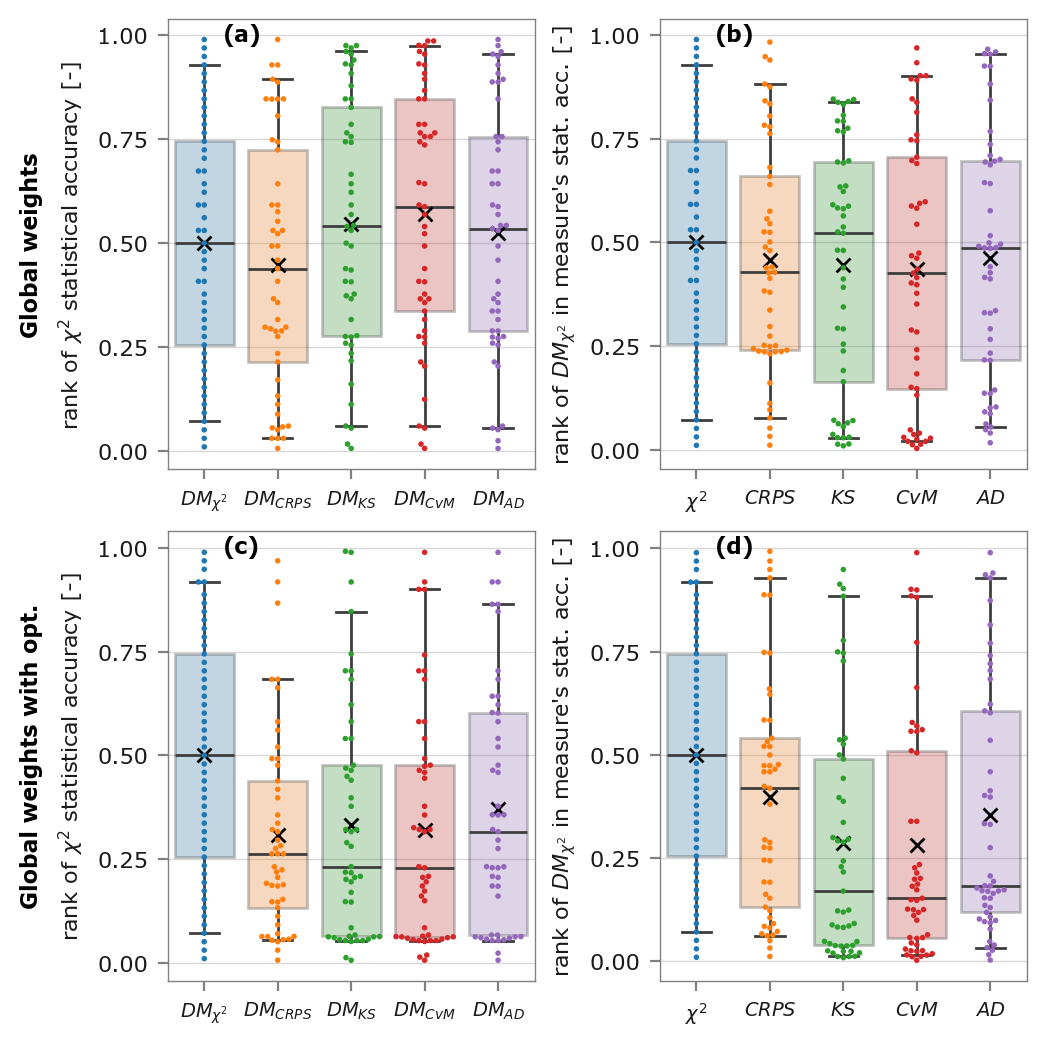

In [21]:
plotting.set_rcparams()

weight_sa = "Chi-square"
weight_sa_label = '${\chi^2}$'
# weight_sa = 'CRPS'
# weight_sa = 'Cramer-von Mises'
# weight_sa = 'Anderson-Darling'

meanprops={"marker":"x",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"}

methods = ["Chi-square", "CRPS", "Kolmogorov-Smirnov", "Cramer-von Mises", "Anderson-Darling"]
labels1 = ['$DM_{\chi^2}$', "$DM_{CRPS}$", "$DM_{KS}$", "$DM_{CvM}$", "$DM_{AD}$"]
labels2 = ['${\chi^2}$', "${CRPS}$", "${KS}$", "${CvM}$", "${AD}$"]
distribution = "PWL"
DM = "GL"

fig, axss = plt.subplots(figsize=(13 / 2.54, 13 / 2.54), constrained_layout=True, ncols=2, nrows=2)

for axs, DM in zip(axss, ['GL', 'GLopt']):
    ax = axs[0]
    # ax.set_title(f"How {weight_sa_label} judges other tests' weights", fontsize=8)
    
    slcA = df2.loc[(distribution, DM, slice(None), weight_sa)].T[methods].copy()
    # slcA.index = pd.CategoricalIndex(methods)
    slcB = df2.loc[(distribution, DM, weight_sa, slice(None))].T[methods].copy()
    
    sns.swarmplot(data=slcA, ax=ax, size=2)
    sns.boxplot(data=slcA, ax=ax, boxprops=dict(alpha=0.3), showmeans=True, meanprops=meanprops, whis=(5, 95), fliersize=0)
    
    ax = axs[1]
    # ax.set_title(f"How other tests judge {weight_sa_label}'s weights", fontsize=8)
    
    sns.swarmplot(data=slcB, ax=ax, size=2)
    sns.boxplot(data=slcB, ax=ax, boxprops=dict(alpha=0.3), showmeans=True, meanprops=meanprops, whis=(5, 95), fliersize=0)
    
    # labels = [
    #     t.get_text().replace("-", "-\n") if not t.get_text().startswith("Chi") else t.get_text()
    #     for t in ax.get_xticklabels()
    # ]
    for i, ax in enumerate(axs):
    
        ax.grid(axis="y", alpha=0.5)
        ax.set(yticks=[0, 0.25, 0.5, 0.75, 1.0], ylabel="rank of ${\chi^2}$ statistical accuracy [-]" if i == 0 else "rank of $DM_{\chi^2}$ in measure's stat. acc. [-]")
        ax.set_xticklabels(labels1 if i == 0 else labels2, fontsize=7)
    
    # c = "grey"
    # for ax in axs.flat:
    #     ax.tick_params(color=c, labelcolor=".1")
    #     for spine in ax.spines.values():
    #         spine.set_edgecolor(c)
    
    
plotting.add_panel_letters(axss, pos=(0.15, 0.99), fmt="({})", transpose=False)

plotting.add_headers(
    fig,
    row_headers=["Global weights", "Global weights with opt."],
    col_headers=None,
    rotate_row_headers=True,
    fontweight='bold'
)
    
    # plt.subplots_adjust(wspace=.2, hspace=.2)
    
    # fig.subplots_adjust(hspace=.2, wspace=1.5)
    
    # plt.tight_layout(pad=0.0, h_pad=0, w_pad=1)
    
# fig.savefig(f"./figures/chi2_cross_comp.pdf", pad_inches=0.001, bbox_inches="tight")

In [23]:
make_bold = lambda x: 'textbf:--rwrap;'

def underline(val):
    return f"cmul[c{int(val*100):02d}]:--rwrap;"

cm = plt.cm.coolwarm_r

abbrev = {
    "CRPS": "CRPS",
    "Cramer-von Mises": "CvM",
    "Kolmogorov-Smirnov": "KS",
    "Chi-square": '${\chi^2}$',
    "Anderson-Darling": "AD",
}

tmp_df = df.unstack().reindex(dists+['EQ'], level=2).reindex(dists, axis=1).rename(columns=abbrev, index=abbrev)
tmp_df = tmp_df.loc[['PWL', 'Metalog'], :]
tmp_df["Mean"] = tmp_df.mean(axis=1)
# tmp_df["Mean"] = (tmp_df.mean(axis=1) - 0.5) * (4 / 3) + 0.5

tmp_df = (
    tmp_df.style.applymap(make_bold, subset="Mean").applymap(underline, )
#     .background_gradient(cmap=cm, vmin=0, vmax=1, axis=None)
    .format(decimal=".", thousands=",", precision=2)
)

tmp_df

C:\Users\gwfrongen\AppData\Local\Temp\ipykernel_13784\1027289535.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  tmp_df.style.applymap(make_bold, subset="Mean").applymap(underline, )


In [24]:
with open('../data/tables/cross_comp_with_info.tex', 'w') as f:
    for i, c in enumerate(np.linspace(-0.6, 1.6, 101, dtype=float)):
        
        f.write('\definecolor{{c{:02d}}}{{rgb}}{{{:.4f},{:.4f},{:.4f}}}\n'.format(i, *cm(c)))
    f.write(tmp_df.to_latex(hrules=True, clines='skip-last;data'))

In [ ]:
from itertools import product

plotting.set_rcparams()

# weight_sa = 'CRPS'
# weight_sa = 'Cramer-von Mises'
# weight_sa = 'Anderson-Darling'

meanprops={"marker":"x",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"}

methods = ["Chi-square", "CRPS", "Kolmogorov-Smirnov", "Cramer-von Mises", "Anderson-Darling"]
labels = ['$DM_{\chi^2}$', "$DM_{CRPS}$", "$DM_{KS}$", "$DM_{CvM}$", "$DM_{AD}$"]
distribution = "PWL"
DM = "GL"

fig, axss = plt.subplots(figsize=(25 / 2.54, 25 / 2.54), constrained_layout=True, ncols=5, nrows=4, sharey=True)

combs = list(product(distributions[::-1], ["GL", "GLopt"]))

for i, (dist_cm, axrow) in enumerate(zip(combs, axss)):

    for j, (weight_sa, ax) in enumerate(zip(methods, axrow)):
        weight_sa_label = labels[j]

        distribution, DM = dist_cm


        slcA = df2.loc[(distribution, DM, slice(None), weight_sa)].T[methods].copy()
    
        sns.swarmplot(data=slcA, ax=ax, size=1.75)
        sns.boxplot(data=slcA, ax=ax, boxprops=dict(alpha=0.3), showmeans=True, meanprops=meanprops, whis=(5, 95), fliersize=0)
        
    # for i, ax in enumerate(axs):
    
        ax.grid(axis="y", alpha=0.5)
        ax.set(yticks=[0, 0.25, 0.5, 0.75, 1.0], ylabel="rank of measure's stat. acc. [-]" if j == 0 else "")
        ax.set_xticklabels(labels, fontsize=7)

    # c = "grey"
    # for ax in axs.flat:
    #     ax.tick_params(color=c, labelcolor=".1")
    #     for spine in ax.spines.values():
    #         spine.set_edgecolor(c)
    
plotting.add_headers(
    fig,
    row_headers=[f'{c[0]} - {c[1]}' for c in combs],
    col_headers=methods,
    rotate_row_headers=True,
    fontweight='bold'
)

plotting.add_panel_letters(axss, pos=(0.02, 0.99), fmt = '{}', transpose=False)
    
    # plt.subplots_adjust(wspace=.2, hspace=.2)
    
    # fig.subplots_adjust(hspace=.2, wspace=1.5)
    
    # plt.tight_layout(pad=0.0, h_pad=0, w_pad=1)
    
fig.savefig(f"../data/figures/cross_comp_all.pdf", pad_inches=0.001, bbox_inches="tight")

C:\Users\gwfrongen\AppData\Local\Temp\ipykernel_13784\572454178.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=7)
C:\Users\gwfrongen\AppData\Local\Temp\ipykernel_13784\572454178.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=7)
C:\Users\gwfrongen\AppData\Local\Temp\ipykernel_13784\572454178.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=7)
C:\Users\gwfrongen\AppData\Local\Temp\ipykernel_13784\572454178.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=7)
C:\Users\gwfrongen\AppData\Local\Temp\ipykernel_13784\572454178.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=7)
C:\Users\gwfrongen\AppData\Local\Temp\ipykernel_13784\572454178.p